# How does transfer learning impact neural networks?

**Authors**:
- Adam Klekowski
- Paweł Kruczkiewicz
- Piotr Makarewicz

*(opis problemu)*

## Preparation
### Importing libraries

In [19]:
import os
import time

import numpy as np
import tensorflow as tf
from tensorflow import keras


import matplotlib.pyplot as plt


### Utility functions

In [ ]:
## consts
INPUT_SHAPE = (256, 256, 3)
BATCH_SIZE = 64

In [12]:
# Class and function for showing the chart of validation accuracy and loss

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

def plot_train_results(history, times, title):
    h = history.history
    loss, acc, val_loss, val_acc = h["loss"], h["categorical_accuracy"], h["val_loss"], h["val_categorical_accuracy"]
    avg_epoch_time = np.round(np.mean(times), 1)
    x = np.arange(len(loss)) + 1

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f"{title} [Avg epoch time: {avg_epoch_time} s]")
    
    ax1.set_title("accuracy")
    ax1.plot(x, acc, label="Test")
    ax1.plot(x, val_acc, label="Validation")
    ax1.set_ylim([0, 1])
    ax1.legend()
    
    ax2.set_title("loss")
    ax2.plot(x, loss, label="Test")
    ax2.plot(x, val_loss, label="Validation")
    ax2.set_ylim([0, 5])
    ax2.legend()  
    
    
# training the model and plotting training results
def train_and_check_model(model, model_name, t_ds, v_ds, epochs=150, lr_scale=1):
    time_history = TimeHistory()

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001*lr_scale),
                  loss="categorical_crossentropy", metrics=[keras.metrics.CategoricalAccuracy()])
    history = model.fit(t_ds,
                    validation_data=v_ds,
                    batch_size=BATCH_SIZE,
                    epochs=epochs,
                    callbacks=[time_history])

    model.save(f"../models/{model_name}")
    
    plot_train_results(history, time_history.times, model_name)

### Importing data

In [4]:
train_ds, validation_ds = keras.utils.image_dataset_from_directory(
    directory='data/',
    label_mode='categorical',
    image_size=(256, 256),
    validation_split=0.4,
    subset="both",
    seed=21)

Found 101000 files belonging to 101 classes.
Using 60600 files for training.
Using 40400 files for validation.


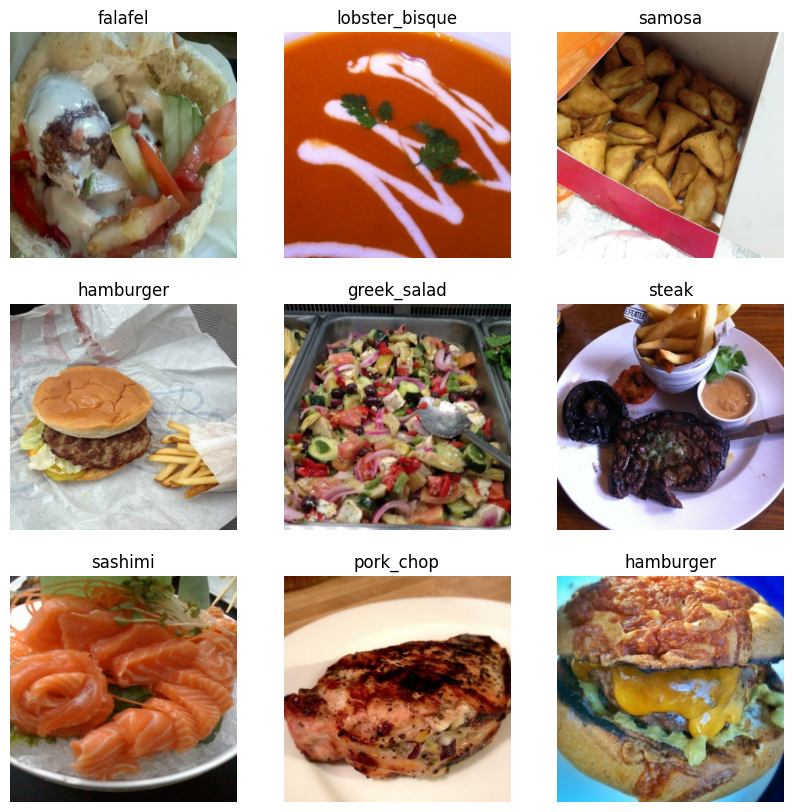

In [5]:
labels = os.listdir("data/")

plt.figure(figsize=(10,10))

for (batch_of_images, batch_of_labels) in train_ds.take(1):
    batch_of_images = batch_of_images[:9]
    batch_of_labels = batch_of_labels[:9]
    for i, (image, inferred_label) in enumerate(zip(batch_of_images, batch_of_labels)):
        image = image / 255
        label = labels[np.nonzero(np.array(inferred_label))[0][0]]
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(label)
        plt.axis("off")

## ConvNext Tiny

### Using ConvNext "as is"

In [7]:
conv_next_model = keras.applications.ConvNeXtTiny(
    model_name="convnext_tiny",
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

conv_next_model.summary()

Model: "convnext_tiny"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_tiny_prestem_normaliz  (None, 256, 256, 3)  0          ['input_1[0][0]']                
 ation (Normalization)                                                                            
                                                                                                  
 convnext_tiny_stem (Sequential  (None, 64, 64, 96)  4896        ['convnext_tiny_prestem_normaliza
 )                                                               tion[0][0]']         

In [15]:
def create_transferred_model(base_model):
    base_model.trainable = False   # 🔫👮‍♂️ Freezing the base model

    inputs = keras.Input(shape=(256, 256, 3), batch_size=32)
    scaled = keras.layers.Rescaling(scale=1./255.)(inputs) 
    
    x_base = base_model(scaled, training=False)
    gap_layer = keras.layers.GlobalAveragePooling2D()(x_base)
    
    outputs = keras.layers.Dense(101, activation="softmax")(gap_layer)
    return keras.models.Model(inputs, outputs)


In [16]:
transferred_model = create_transferred_model(conv_next_model)
transferred_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(32, 256, 256, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (32, 256, 256, 3)         0         
                                                                 
 convnext_tiny (Functional)  (None, 8, 8, 768)         27820128  
                                                                 
 global_average_pooling2d_1   (32, 768)                0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (32, 101)                 77669     
                                                                 
Total params: 27,897,797
Trainable params: 77,669
Non-trainable params: 27,820,128
__________________________________________

In [23]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [20]:
train_and_check_model(transferred_model, "Transfer learning model", t_ds=train_ds, v_ds=validation_ds, epochs=3)

Epoch 1/3
  16/1894 [..............................] - ETA: 11:43:27 - loss: 5.0414 - categorical_accuracy: 0.0039

KeyboardInterrupt: 